In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")
# import tqdm
# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import ipdb

import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# import ipdb
import platform
import h5py
import scipy.io
opj = os.path.join
deb = ipdb.set_trace

# MRI imports
# -----------
import nibabel as nb
import cortex
from nipype.interfaces.freesurfer import SurfaceTransform

# Popeye imports
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.css as css
import popeye.og as og

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get inputs
# ----------
subject = 'sub-01'
fit_model = 'gauss'

# Define analysis parameters
# --------------------------
with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
if 'aeneas' in platform.uname()[1]:
    base_dir = analysis_info['aeneas_base_folder'] 
elif 'lisa' in platform.uname()[1]:
    base_dir = analysis_info['lisa_base_folder'] 

deriv_dir = opj(base_dir,'pp_data',subject,fit_model,'deriv')
roi_masks_dir = opj(base_dir,'pp_data',subject,fit_model,'roi_masks')
h5_dir = opj(base_dir,'pp_data',subject,fit_model,'h5')
try: os.makedirs(roi_masks_dir)
except OSError: pass

sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11

In [11]:
draw_hemi = 0

# Initialize data dictionary that will save all data arrays
for roi_num, roi in enumerate(analysis_info['rois']):
    if roi == 'V2':
        for mask_dir in ['pos']:    
            data_hemi = []
            val_hemi = 0
            tc_mat_hemi = []

            for hemi in ['L', 'R', 'LR']:
                # create folder
                roi_text = roi
                # load data
                if hemi == 'LR':
                    data = np.row_stack((data_hemi[0],data_hemi[1]))
                    tc_mat = np.row_stack((tc_mat_hemi[0],tc_mat_hemi[1]))
                    draw = True

                else:
                    # derivative data
                    if hemi == 'L': val_hemi = 1
                    elif hemi == 'R': val_hemi = 2
                    folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
                    h5_file = h5py.File(opj(h5_dir,'{roi}.h5'.format(roi = roi_text)), "r")
                    in_file = opj("prf_deriv_{hemi}_{mask_dir}".format(hemi = hemi, mask_dir = mask_dir))
                    data = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]
                    data = np.vstack((data,val_hemi*np.ones((1,data.shape[1]))))
                    data = data[:,:].T
                    data_hemi.append(data)
                    if draw_hemi == 1:
                        draw = True
                    elif draw_hemi == 0:
                        draw = False

                    # time course data
                    if hemi == 'L' or hemi == 'R':
                        mask_file = opj(roi_masks_dir,"masks_{hemi}_fsaverage6.gii".format(hemi = hemi))
                        gii_in_mask = nb.load(mask_file)
                        mask_mat = np.array([gii_in_mask.darrays[i].data for i in range(len(gii_in_mask.darrays))])

                        # load time course of original data
                        orig_data_file  =  sorted(glob.glob(opj(base_dir,'raw_data',subject,"{sub}_task-prf_space-fsaverage6_hemi-{hemi}.func_sg_psc.gii".format(sub = subject, hemi = hemi))))
                        orig_data_file_load = nb.load(orig_data_file[0])
                        orig_data = []
                        orig_data.append(np.array([orig_data_file_load.darrays[i].data for i in range(len(orig_data_file_load.darrays))]))
                        orig_data = np.vstack(orig_data)

                    # select corresponding time course
                    mask_mat_roi = mask_mat[roi_num,:]
                    mask_mat_roi = np.round(mask_mat_roi)
                    tc_mat = orig_data[:, mask_mat_roi==1].T
                    tc_mat_hemi.append(tc_mat)



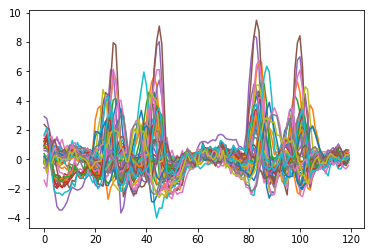

In [12]:
plt.plot(tc_mat_hemi[0][:50].T);

In [13]:
# Create stimulus design
visual_dm_file = scipy.io.loadmat(opj(base_dir,'raw_data','vis_design.mat'))
visual_dm = visual_dm_file['stim']

stimulus = VisualStimulus(  stim_arr = visual_dm,
                            viewing_distance = analysis_info["screen_distance"],
                            screen_width = analysis_info["screen_width"],
                            scale_factor = 1/10.0,
                            tr_length = analysis_info["TR"],
                            dtype = np.short)

model_func = og.GaussianModel(  stimulus = stimulus,
                                hrf_model = utils.spm_hrf)

model_func.hrf_delay = 0

In [14]:
predicted_data = np.array([model_func.generate_prediction(data[i,x_idx], data[i,y_idx], data[i,size_idx], data[i,amp_idx]/100, data[i,baseline_idx]*100) for i in range(data.shape[0])])

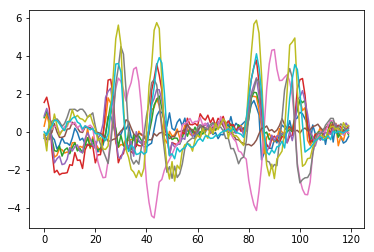

In [15]:
plt.plot(tc_mat[100:110].T)

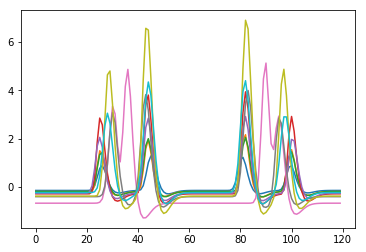

In [16]:
plt.plot(predicted_data[100:110].T)

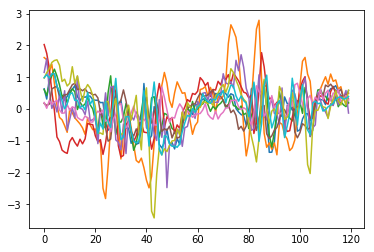

In [46]:
# plt.plot(predicted_data[0:10].T)
# plt.plot(tc_mat[0:10].T)
plt.plot(tc_mat[0:10].T-predicted_data[0:10].T)

In [108]:
from popeye.spinach import generate_og_receptive_fields
extent = [-10,10]
n_pix = 30
deg_x, deg_y = np.meshgrid(np.linspace(extent[0], extent[1], n_pix, endpoint=True), 
                           np.linspace(extent[0], extent[1], n_pix, endpoint=True))

rfs = generate_og_receptive_fields(data[:,x_idx], 
                                   data[:,y_idx], 
                                   data[:,size_idx],
                                   np.ones(data.shape[0]),
                                   deg_x, 
                                   deg_y)

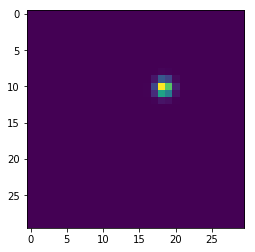

In [109]:
plt.imshow(rfs[:,:,0])

In [110]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import arpack

def fit_model_omega(observed_residual_covariance, WWT, D=None, infile=None, outfile=None, verbose=0):
    if D!=None:
        if not isPSD(D, tol = 1e-3):
            print("Please check the distance matrix provided. It appears to not be suitable.")
            return None
    
    if not isPSD(observed_residual_covariance, tol = 1e-3):
        print("Please check the residual covaricne matrix provided. It appears to not be a suitable covariance matrix.")
        return None
    
   # or if possible load the result of the previous minimization
    if infile != None:
        x0=np.load(infile)
        initial_guesses = 1
    else:   # initial guesses around Van Bergen values
        initial_guesses = 2
        x0=np.zeros((observed_residual_covariance.shape[0]+3,initial_guesses))
        x0[0,:] = 0.0 #alpha
        x0[1,:] = 0.2 # rho
        x0[2,:] = 7.5 # sigma
        x0[3:,:] = 0.5 * np.ones((observed_residual_covariance.shape[0], initial_guesses)) + \
                0.2 * np.random.randn( observed_residual_covariance.shape[0], initial_guesses)
#        x0[2:,:] = np.zeros((observed_residual_covariance.shape[0], initial_guesses))

    
    #suitable boundaries determined experimenally    
    bnds = [(-500,500) for xs in x0[:,0]]
    if D==None:
        bnds[0]=(0,0)
        
    bnds[1]=(0,1)
    bnds[2]=(0,500)
    
    def f(x, residual_covariance, WWT, Distance):
        alpha=x[0]
        rho=x[1]
        sigma=x[2]
        #tried to use the all_residual_covariance as tau_matrix: optimization fails (maybe use it as initial values for search. tried & failed)
        #tried to use stimulus_covariance as WWT: search was interrupted as it becomes several order of magnitudes slower.
        tau_matrix = np.outer(x[3:],x[3:])
        
        unique_variance = np.eye(tau_matrix.shape[0]) * (1-rho) * tau_matrix
        shared_variance = tau_matrix * rho
        
        
        if Distance==None:
            omega = shared_variance + unique_variance + (sigma**2) * WWT
        else:
            distance_variance = alpha * Distance * tau_matrix
            omega = distance_variance + shared_variance + unique_variance + (sigma**2) * WWT
        
        return np.sum(np.square(residual_covariance - omega))
    
    #minimize distance between model covariance and observed covariance
    #This routine allows computation starting from multiple different initial conditions, in an attempt to avoid local minima
    best_fun=0
    for k in range(x0.shape[1]):
        result=sp.optimize.minimize(f, 
                                    x0[:,k], 
                                    args=(observed_residual_covariance, WWT,D), 
                                    method='L-BFGS-B', 
                                    bounds=bnds,
                                    tol=1e-02,
                                    options={'disp':True})
        if k==0:
            best_fun=result.fun
            best_result=result
        if result.fun <= best_fun:
            best_fun=result.fun
            best_result=result
            
    better_result=sp.optimize.minimize(f, 
                                       best_result['x'], 
                                       args=(observed_residual_covariance, WWT,D), 
                                       method='L-BFGS-B', 
                                       bounds=bnds, 
                                       tol=1e-06, 
                                       options={'disp':True,'maxfun': 15000000, 'factr': 10})
    
    #extract model covariance parameters and build omega
    x=better_result.x
    estimated_tau_matrix=np.outer(x[3:],x[3:])
    estimated_alpha=x[0]
    estimated_rho=x[1]
    estimated_sigma=x[2]
    
    if D==None:
        model_omega=estimated_rho*estimated_tau_matrix+(1-estimated_rho)*np.multiply(np.identity(estimated_tau_matrix.shape[0]),estimated_tau_matrix)+(estimated_sigma**2)*WWT
    else:
        model_omega=estimated_alpha*D*estimated_tau_matrix + estimated_rho*estimated_tau_matrix+(1-estimated_rho)*np.multiply(np.identity(estimated_tau_matrix.shape[0]),estimated_tau_matrix)+(estimated_sigma**2)*WWT
    
    model_omega_inv = np.linalg.inv(model_omega)
    logdet = np.linalg.slogdet(model_omega)
    
    if not isPSD(model_omega, tol = 1e-3):
        print("The fit model omega appears to not be a suitable covariance matrix.")
        return None

    if outfile != None:
        np.save(outfile,x)

    if verbose > 0:
        #print some details about omega for inspection and save
        print("max tau: "+str(np.max(x[3:]))+" min tau: "+str(np.min(x[3:])))
        print("sigma: "+str(estimated_sigma)+" rho: "+str(estimated_rho)+" alpha: "+str(estimated_alpha))
        #How good is the result?
        print("summed squared distance: "+str(np.sum(np.square(observed_residual_covariance-model_omega))))
        #Some sanity checks. 
        #Notice that determinants of data covariance and model covariance are extremely small, need to take log to make them manageable
        #print(np.linalg.slogdet(all_residual_covariance_css))
        #print(np.linalg.slogdet(model_omega))
    
    #The first test-optimization of parameters was done with a very rough 0.01 precision (distance ~7*10^5)
    #0.001 precision increased computational time and reduced distance (now ~6*10^5)
    #on server: ~3.9*10^5

    return estimated_tau_matrix, estimated_rho, estimated_sigma, estimated_alpha, model_omega, model_omega_inv, logdet

#function for some sanity checks within the omega estimation procedure

def isPSD(A, tol = 1e-8):
    vals = np.linalg.eigvalsh(A) # return the ends of spectrum of A
    return np.all(vals > -tol)

(array([ 113.,    1.,    2.,   15.,   28.,   42.,   71.,  130.,  240.,  268.]),
 array([ 0.        ,  0.09191871,  0.18383741,  0.27575612,  0.36767483,
         0.45959353,  0.55151224,  0.64343095,  0.73534966,  0.82726836,
         0.91918707]),
 <a list of 10 Patch objects>)

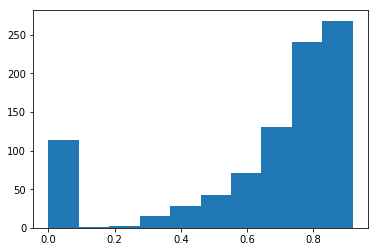

In [111]:
plt.hist(np.nan_to_num(data[:,rsq_idx]))

In [112]:
residuals = tc_mat-predicted_data
rfs_res = rfs.reshape((-1,residuals.shape[0])).T

rsq_threshold = 0.8
rsq_mask = data[:,rsq_idx] > rsq_threshold

estimated_tau_matrix, estimated_rho, estimated_sigma, estimated_alpha, model_omega, model_omega_inv, logdet = \
    fit_model_omega(np.cov(residuals[rsq_mask]), np.dot(rfs_res[rsq_mask], rfs_res[rsq_mask].T), D=None, infile=None, outfile=None, verbose=0)

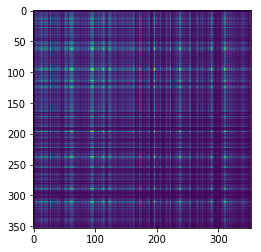

In [113]:
plt.imshow(estimated_tau_matrix);

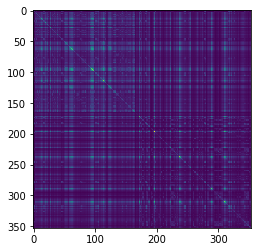

In [114]:
plt.imshow(model_omega);

In [115]:
def firstpass_decoder_independent_channels( W,
                                            bold, 
                                            logdet,
                                            omega_inv,
                                            mapping_relation=None,
                                            mapping_parameters=[]):
    if logdet[0]!=1.0:
        print('Error: model covariance has negative or zero determinant')
        return
    const=-0.5*(logdet[1]+omega_inv.shape[0]*np.log(2*np.pi))
    
    #1 extra column for empty screen baseline
    non_linear_predictor_independent_channels =  np.zeros((W.shape[0], W.shape[1]+1))
    non_linear_predictor_independent_channels[:,1:]=np.copy(W)
    
    # possible mappings to implement nonlinear transformation
    if mapping_relation != None:
        if type(mapping_relation) == list:         
            for i, mr in enumerate(mapping_relation):
                non_linear_predictor_independent_channels = mapping(non_linear_predictor_independent_channels, mapping_relation=mr, parameters=mapping_parameters[i])
        else:
            non_linear_predictor_independent_channels = mapping(non_linear_predictor_independent_channels, mapping_relation=mapping_relation, parameters=mapping_parameters)
            
#     print(non_linear_predictor_independent_channels.shape)
    # difference between bold response and linear predictor is residuals
    resid=np.tile(bold,(non_linear_predictor_independent_channels.shape[1],1)).T-non_linear_predictor_independent_channels
#     resid = bold-non_linear_predictor_independent_channels
    # actual calculation here
    log_likelihood_indep_Ws=const - 0.5 * (resid * omega_inv.dot(resid)).sum(0)
    
    # all ll relative to 0, the empty screen
    baseline=log_likelihood_indep_Ws[0]
    
    # firstpass_image=np.reshape(baseline/log_likelihood_indep_pixels[1:],(mask.shape[0],mask.shape[1]))
    firstpass_image=baseline/log_likelihood_indep_Ws[1:]

    firstpass_image_normalized=(firstpass_image-np.min(firstpass_image))/(np.max(firstpass_image)-np.min(firstpass_image))
    
    return firstpass_image_normalized

In [116]:
W = rfs_res[rsq_mask]
bold_data = tc_mat[rsq_mask]
omega_inv = model_omega_inv
# test data to use the cv data
dm_pixel_logl_ratio = np.zeros((W.shape[1],bold_data.shape[1]))

# and loop across timepoints
for t, bold in enumerate(bold_data.T):
    dm_pixel_logl_ratio[:,t] = firstpass_decoder_independent_channels(
                                        W=W,
                                        bold=bold, 
                                        logdet=logdet,
                                        omega_inv=omega_inv
                                        )

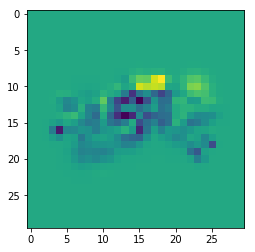

In [117]:
plt.imshow(dm_pixel_logl_ratio[:,32].reshape([n_pix,n_pix]))

In [133]:
def calculate_bold_loglikelihood(   stimulus,
                                    W,
                                    bold,
                                    logdet,                                    
                                    omega_inv,
                                    mapping_relation=None,
                                    mapping_parameters=[]):

    const=-0.5*(logdet[1]+omega_inv.shape[0]*np.log(2*np.pi))

    linear_predictor = np.dot(W,stimulus)

    # possible mappings to implement nonlinear transformation
    if mapping_relation != None:
        if type(mapping_relation) == list:
            non_linear_predictor = linear_predictor
            for i, mr in enumerate(mapping_relation):
                non_linear_predictor = mapping(non_linear_predictor, mapping_relation=mr, parameters=mapping_parameters[i])
        else:
            non_linear_predictor = mapping(linear_predictor, mapping_relation=mapping_relation, parameters=mapping_parameters)
    else:
        non_linear_predictor = linear_predictor
    
    resid = bold - non_linear_predictor

    log_likelihood = const - 0.5 * np.dot(resid, np.dot(omega_inv, resid))

    return -log_likelihood

#simple function using Python built-in minimizer to get a more accurate reconstruction
#returns: optimized decoded stimulus and associated loglikelihood.    
def maximize_loglikelihood( starting_value,
                            W,                           
                            bold,
                            logdet,
                            omega_inv,                            
                            mapping_relation=None,
                            mapping_parameters=[]):
    bnds=[(0,1) for elem in starting_value]

    final_result=sp.optimize.minimize(
                                    calculate_bold_loglikelihood, 
                                    starting_value, 
                                    args=(  W,
                                            bold,
                                            logdet,
                                            omega_inv,                            
                                            mapping_relation,
                                            mapping_parameters), 
                                    method='L-BFGS-B', 
                                    bounds=bnds,
                                    tol=1e-03,
                                    options={'disp':True})
    decoded_stimulus = final_result.x
    logl = -final_result.fun
    return logl, decoded_stimulus

In [134]:
decoded_image = np.zeros((W.shape[1],bold_data.shape[1]))
for t, bold in enumerate(bold_data.T):
    logl, decoded_image[:,t] = maximize_loglikelihood( starting_value=dm_pixel_logl_ratio[:,t],
                            W=W,                           
                            bold=bold,
                            logdet=logdet,
                            omega_inv=omega_inv)
#     print(t)

(array([ 203.,   32.,   23.,   20.,   49.,  564.,    1.,    2.,    1.,    5.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

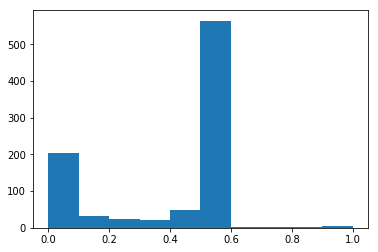

In [122]:
plt.hist(decoded_image[:,55])

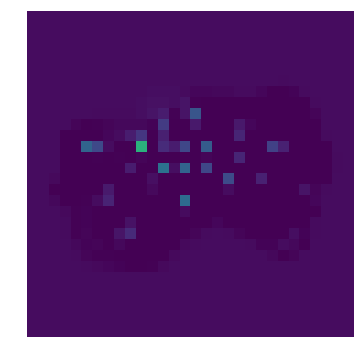

In [135]:
import matplotlib.animation as animation
recon = np.zeros([decoded_image.shape[1]]+[n_pix, n_pix] )

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(decoded_image.shape[1]):
    recon[t] = decoded_image[:,t].reshape((n_pix, n_pix))

    im = pl.imshow(recon[t], animated=True, cmap='viridis',clim=[0,1])
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani